<center>
<h1> Algorithmic Trading </h1>
<h2> Buy Low Sell High: a High Frequency Trading Perspective </h1>
<h3> Youssef BULAHIA </h3>

The aim of this notebook is to implement a simulation of a High Frequency Trading strategy presented in the paper "Buy Low Sell High: a High Frequency Trading Perspective" by Alvaro Cartea, Sebastian Jaimungal, Jason Ricci.

In this High Frequency trading (HF) strategy, the HF trader uses her superior speed to process information and to post limit sell and buy orders.
A unique characteristic to HF trading is that the strategies are designed to hold close to
no inventories over very short periods of time (seconds, minutes, or at most one day) to avoid both
exposure to markets after close and to post collateral overnight. Thus, profits are made by turning
over positions very quickly to make a very small margin per roundtrip transaction (buy followed by
a sell or vice-versa), but repeating it as many times as possible during each trading day.

we will apply the simulation study of the HF strategy that is presented in the paper, where market orders, buy and sell,are generated over a period of 5 minutes (maturity).

The main purpose at the end, is simulating the PnL distribution of the High Frequency strategy in term of different parameters.

We will start by importing all the packages used in the following steps of the simulation.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from math import exp, log
from mpmath import mp

First of all, we will initiate all the parameters that we need to develop this strategy.
We assume that news does not arrive during the simulation and assume the following values for the parameters :  

In [5]:
# Speed and level of mean reversion of intensity of Market Order (MO) arrivals :
β = 60
θ = 1

# Jumps in λ_t upon the arrival of influential MOs :
η = 40
ν = 10

# Speed and level of mean reversion for the κt process :
ξ = 10
ϑ_ = 50

# Jumps in κ_t upon the arrival of influential MOs :
η_κ = 10
ν_κ = 25

# long-term component of the drift of the midprice :
υ = 0

# Volatility of diffusion component of the midprice :
σ_ = 0.01

# Speed of mean reversion and volatility of diffusion component of α_t process :
ζ = 2
σ_α = 0.01

# Maturity in seconds :
T = 300

Here, we will define the main function of the HFT strategy.

The stochastic drift $α_t$, fill probabilites $κ_t$, market orders activities $λ_t$, midprices S, cash X, PnL, and optimal postings $δ_t$ are all calculated using the assumptions and propositions in the paper that provides many explicit expressions for implementation.

We note that the strategy is under an exponential fill rate, which means that $h_t = e^{-κ_t δ_t}$.

In [6]:
def HFT_Strategy(n, ρ, φ, ε, c_trans, alpha) : 

    # Results stock
    S_samples = []
    S_plus_δ_samples = []
    S_minus_δ_samples = []
    X_samples = []
    time_samples = []
    PnLs = []
    α_updated_samples = []
    λ_plus_updated_samples = []
    λ_minus_updated_samples = []
    κ_plus_samples = []
    κ_minus_samples = []

    for i in range(n):
        # The starting mid price :
        S = [100]
        S_plus_δ = [100]
        S_minus_δ = [100]

        # The starting drift :
        α = [0]
        α_updated = [0]

        # The buy/sell indicator :
        B = []

        # The inventory : 
        X = [0]

        # The agent cash :
        q = [0]

        time = [0]
        λ_plus = [1]
        λ_minus = [1]
        λ_plus_updated = [1]
        λ_minus_updated = [1]
        κ_plus = [2] 
        κ_minus = [1.01]
        δ_plus = 0
        δ_minus = 0
        Tn_plus_1 = 0

        while (time[-1] + Tn_plus_1) < T:
            λ = λ_plus_updated[-1] + λ_minus_updated[-1]
            
            u = np.random.uniform(0, 1)
            ς = (1/(2*θ)) * (λ - 2*θ + β * log(u))
            try:
                τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))
            except OverflowError:
                τ = float('inf')
            
            Tn_plus_1 = (1/β) * (τ - ς)

            p_buy = (θ + (λ_plus_updated[-1]-θ)*exp(-β*Tn_plus_1)) / (2*θ+(λ_plus_updated[-1]+λ_minus_updated[-1]-2*θ)*exp(-β*Tn_plus_1))

            cov_1_2 = (σ_**2/(2*ζ**2)) * (1 - 2*exp(-ζ*Tn_plus_1) + exp(-2*ζ*Tn_plus_1))
            cov_1_1 = (σ_**2/(ζ**2)) * (Tn_plus_1 - (2/ζ)*(1 - exp(-ζ*Tn_plus_1)) + (1 - exp(-2*ζ*Tn_plus_1))/(2*ζ))
            cov_2_2 = (σ_**2/(2*ζ)) * (1 - exp(-2*ζ*Tn_plus_1))

            # The correlation is :
            if cov_1_1*cov_2_2 == 0 :
                continue
            else :
                corr_1_2 = cov_1_2 / ((cov_1_1*cov_2_2)**0.5)

            SN_1 = np.random.randn() #First standard normal random variable
            SN_2 = np.random.randn() #Second standard normal random variable
            SN_3 = corr_1_2 * SN_1 + ((1-(corr_1_2**2))**0.5) * SN_2 # Linear combination of the two preceding random variables

            # The two correlated normals are :
            Z_1 = (cov_1_1**0.5) * SN_1
            Z_2 = (cov_2_2**0.5) * SN_3

            # The third independent standard normal :
            Z = np.random.randn()

            # The buy/sell indicator :
            if np.random.uniform(0, 1) < p_buy :
                Bn_plus_1 = 1
                B.append(Bn_plus_1)
            else : 
                Bn_plus_1 = -1
                B.append(Bn_plus_1)

            # Update time :
            time.append(time[-1] + Tn_plus_1)

            # Exact Optimal Controls for Exponential Law :
            beta =  β - ρ*(ν - η)

            b_φ_λ = 2*exp(-1) * (λ_plus_updated[-1] - λ_minus_updated[-1]) * ((1/beta) * Tn_plus_1 - (1-exp(-beta *Tn_plus_1 )) / (beta**2))
            S_λ_bφ_plus = 2*exp(-1) * (λ_plus_updated[-1] - λ_minus_updated[-1] + Bn_plus_1*ν - Bn_plus_1*η) * ((1/beta) * Tn_plus_1 - (1-exp(-beta *Tn_plus_1 )) / (beta**2))
            SS_λ_bφ_plus = ρ * S_λ_bφ_plus + (1-ρ) * b_φ_λ
            SS_λ_bφ_minus = ρ * S_λ_bφ_plus + (1-ρ) * b_φ_λ

            Eα = (ε*ρ/ζ) * (λ_plus_updated[-1] - λ_minus_updated[-1]) * (((1-exp(-beta *Tn_plus_1 )) / beta) - (exp(-ζ *Tn_plus_1)-exp(-beta *Tn_plus_1))/(beta-ζ)) + α_updated[-1] * (1-exp(-ζ *Tn_plus_1))/ζ
            S_λ_Eα_plus = (ε*ρ/ζ) * (λ_plus_updated[-1] - λ_minus_updated[-1] + Bn_plus_1*ν - Bn_plus_1*η) * (((1-exp(-beta *Tn_plus_1 )) / beta) - (exp(-ζ *Tn_plus_1)-exp(-beta *Tn_plus_1))/(beta-ζ)) + (α_updated[-1]+ε) * (1-exp(-ζ *Tn_plus_1))/ζ
            S_λ_Eα_minus = (ε*ρ/ζ) * (λ_plus_updated[-1] - λ_minus_updated[-1] + Bn_plus_1*ν - Bn_plus_1*η) * (((1-exp(-beta *Tn_plus_1 )) / beta) - (exp(-ζ *Tn_plus_1)-exp(-beta *Tn_plus_1))/(beta-ζ)) + (α_updated[-1]-ε) * (1-exp(-ζ *Tn_plus_1))/ζ
            SS_λ_Eα_plus = ρ * S_λ_Eα_plus + (1-ρ) * Eα
            SS_λ_Eα_minus = ρ * S_λ_Eα_minus + (1-ρ) * Eα

            δ_plus = max(((1/κ_plus[-1]) + (1/(2-(1/κ_plus[-1]**2))) *(SS_λ_Eα_plus + φ * (SS_λ_bφ_plus + (1 - 2*q[-1]) * Tn_plus_1))).real,0)
            δ_minus = max(((1/κ_minus[-1]) + (1/(2-(1/κ_minus[-1]**2))) *(-SS_λ_Eα_minus + φ * (-SS_λ_bφ_plus + (1 + 2*q[-1]) * Tn_plus_1))).real,0)

            # Update price :
            S_tn_plus_1 = (S[-1] + α[-1] * (1/ζ) * (1 - exp(-ζ*Tn_plus_1)) + Z_1 + σ_ * (Tn_plus_1**0.5) * Z).real
            S.append(S_tn_plus_1)
            S_plus_δ.append(S_tn_plus_1 + δ_plus)
            S_minus_δ.append(S_tn_plus_1 - δ_minus)

            # Update drift (If alpha == 1 then the the drift is stochastic, otherwise the drift is 0)
            if alpha == 1 : 
                α_n_plus_1 = exp(-ζ*Tn_plus_1)*α[-1] + Z_2
            else :
                α_n_plus_1 = 0
            α.append(α_n_plus_1)

            # Update the inventory and agent's cash :
            X.append(X[-1] + Bn_plus_1*S_tn_plus_1 + δ_plus)
            q.append(q[-1] - Bn_plus_1)

            if np.random.uniform(0, 1) < ρ :
                Hn_plus_1 = 1
            else :
                Hn_plus_1 = 0

            λ_plus_updated.append(θ + (λ_plus_updated[-1]-θ)*exp(-β*Tn_plus_1) + (0.5*(1+Bn_plus_1)*ν + 0.5*(1-Bn_plus_1)*η )*Hn_plus_1)
            λ_minus_updated.append(θ + (λ_minus_updated[-1]-θ)*exp(-β*Tn_plus_1) + (0.5*(1-Bn_plus_1)*ν + 0.5*(1+Bn_plus_1)*η )*Hn_plus_1)

            κ_plus.append(ϑ_ + (κ_plus[-1]-ϑ_)*exp(-ξ*Tn_plus_1) + (0.5*(1+Bn_plus_1)*ν + 0.5*(1-Bn_plus_1)*η )*Hn_plus_1)
            κ_minus.append(ϑ_ + (κ_minus[-1]-ϑ_)*exp(-ξ*Tn_plus_1) + (0.5*(1-Bn_plus_1)*ν + 0.5*(1+Bn_plus_1)*η )*Hn_plus_1)

            if alpha == 1 :
                α_updated.append(0.5*(1+Bn_plus_1)*np.random.exponential(ε) - 0.5*(1-Bn_plus_1)*np.random.exponential(ε) + α_n_plus_1)
            else : 
                α_updated.append(0)
                
        S_samples.append(S)
        S_plus_δ_samples.append(S_plus_δ)
        S_minus_δ_samples.append(S_minus_δ)
        X_samples.append(X)
        time_samples.append(time)
        α_updated_samples.append(α_updated)
        λ_plus_updated_samples.append(λ_plus_updated)
        λ_minus_updated_samples.append(λ_minus_updated)
        κ_plus_samples.append(κ_plus)
        κ_minus_samples.append(κ_minus)

        PnL = (X[-1] + q[-1] * S[-1] * (1 - c_trans * np.sign(q[-1]))).real
        PnLs.append(PnL)
    return (PnLs, S_samples, S_plus_δ_samples, S_minus_δ_samples, time_samples, X_samples, α_updated_samples, λ_plus_updated_samples, λ_minus_updated_samples, κ_plus_samples, κ_minus_samples)

<h3> Case 1 : ε = 0.04 and c_trans = 0.0001 (1 BP)</h3> 

In the first case, we will vary ρ, φ, and the dynamics of alpha (constant or stochastic).

We will generate the mean and standard deviation of the PnL in each case.

To generate the PnL we assume that the final inventory is liquidated at the midprice with different
transactions costs per share : 1 basis point in the first case.

In each simulation the process is repeated 5, 000 times to obtain the PnLs of the various strategies.

 1) Strategy 1 : ρ = 0.7, φ = 0.00001, alpha = 1 (stochastic drift)

In [7]:
HFT1_1 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_1[0]))
print("The PnL standard deviation is :", np.std(HFT1_1[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 17.980662998874244
The PnL standard deviation is : 4.111919325521554


Now, we will choose randomly one of the 5000 simulations, and then we will plot the stochastic drift of the price.

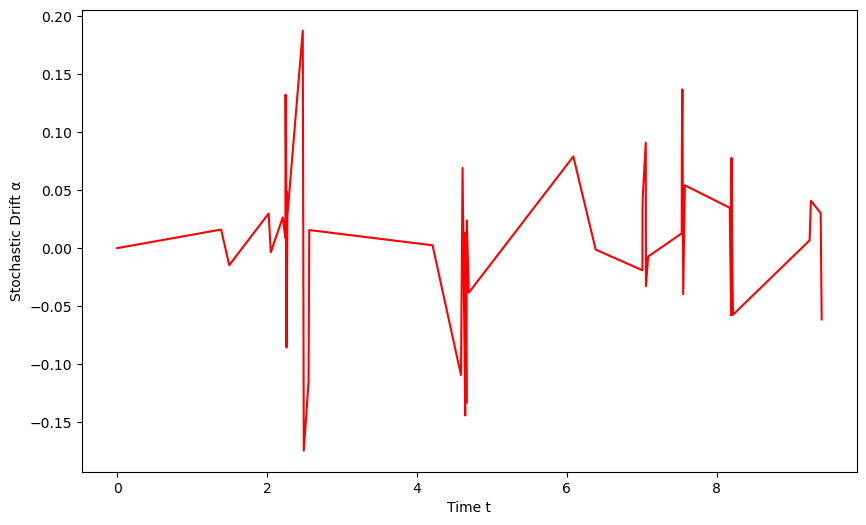

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(HFT1_1[4][30][0:50], HFT1_1[6][30][0:50], color = 'red', label = 'α_updated')
plt.xlabel("Time t")
plt.ylabel("Stochastic Drift α")
plt.show()

In this section, we will plot the market order activities $\lambda^+$ and $\lambda^-$, for the same simulation.

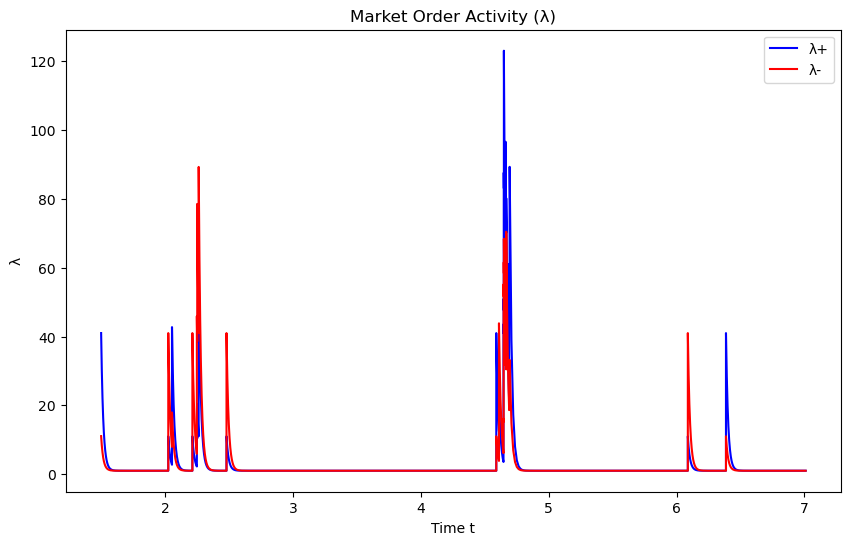

In [9]:
plt.figure(figsize=(10, 6))

x_values = []
λplus_values = []
λminus_values = []

for i in range(2, len(HFT1_1[7][30][0:30])):
    x = np.linspace(HFT1_1[4][30][i], HFT1_1[4][30][i+1], 100)
    
    λplus = θ + (HFT1_1[7][30][i] - θ) * np.exp(-β * (x - HFT1_1[4][30][i]))
    λminus = θ + (HFT1_1[8][30][i] - θ) * np.exp(-β * (x - HFT1_1[4][30][i]))
    
    x_values.extend(x)
    λplus_values.extend(λplus)
    λminus_values.extend(λminus)

plt.plot(x_values, λplus_values, color='blue', label='λ+')
plt.plot(x_values, λminus_values, color='red',label='λ-')

plt.xlabel('Time t')
plt.ylabel('λ')
plt.title('Market Order Activity (λ)')
plt.legend()

plt.show()

In this section, we will plot the fill probabilities $\kappa^+$ and $\kappa^-$, for the same simulation.

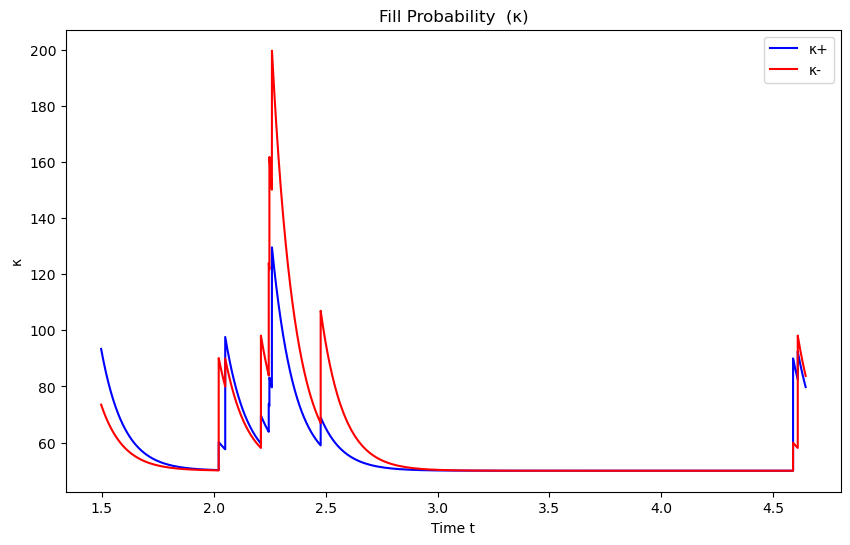

In [10]:
plt.figure(figsize=(10, 6))

x_values = []
κplus_values = []
κminus_values = []

for i in range(2,len(HFT1_1[9][30][0:20])):
    x = np.linspace(HFT1_1[4][30][i], HFT1_1[4][30][i+1], 100)
    
    κplus = ϑ_ + (HFT1_1[9][30][i] - ϑ_) * np.exp(-ξ * (x - HFT1_1[4][30][i]))
    κminus = ϑ_ + (HFT1_1[10][30][i] - ϑ_) * np.exp(-ξ * (x - HFT1_1[4][30][i]))
    
    x_values.extend(x)
    κplus_values.extend(κplus)
    κminus_values.extend(κminus)

plt.plot(x_values, κplus_values, color='blue', label='κ+')
plt.plot(x_values, κminus_values, color='red',label='κ-')

plt.xlabel('Time t')
plt.ylabel('κ')
plt.title('Fill Probability  (κ)')
plt.legend()

plt.show()

Now, we will visualize the price, the limit buy and the limit sell of the same simulation.

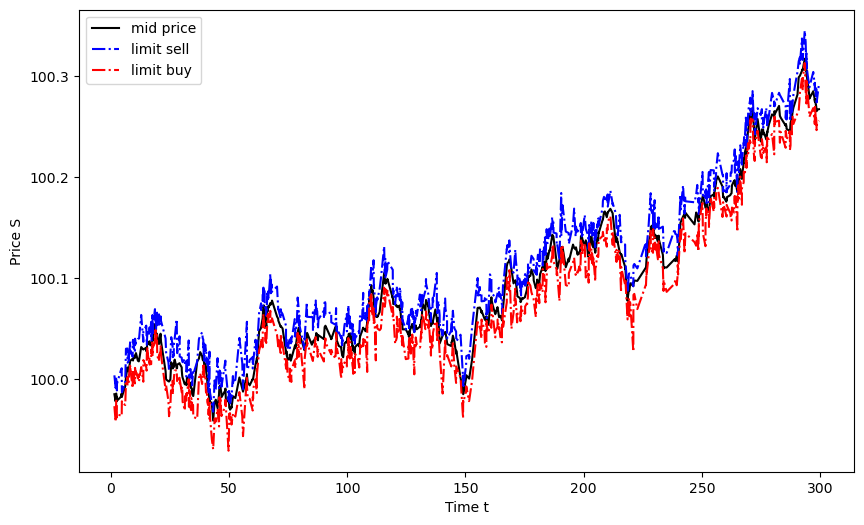

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(HFT1_1[4][30][2:], HFT1_1[1][30][2:], color = 'black',label = 'mid price')
plt.plot(HFT1_1[4][30][2:], HFT1_1[2][30][2:], color = 'blue',label = 'limit sell', linestyle = '-.')
plt.plot(HFT1_1[4][30][2:], HFT1_1[3][30][2:], color = 'red',label = 'limit buy', linestyle = '-.')
plt.xlabel("Time t")
plt.ylabel("Price S")
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.legend()
plt.show()

Here we will plot the agent's cash found for the same simulation.

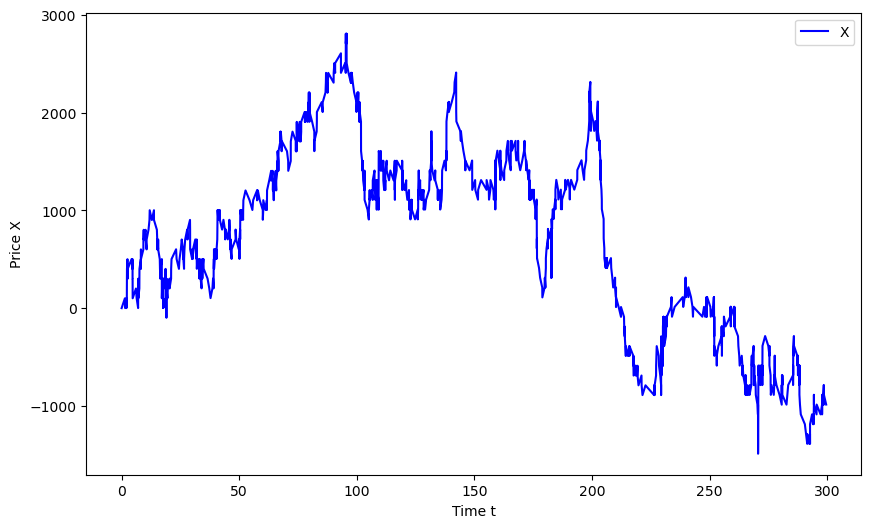

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(HFT1_1[4][30], HFT1_1[5][30], color = 'blue', label = 'X')
plt.xlabel("Time t")
plt.ylabel("Price X")
plt.legend()
plt.show()

And finally, here is the evolution of the PnL :

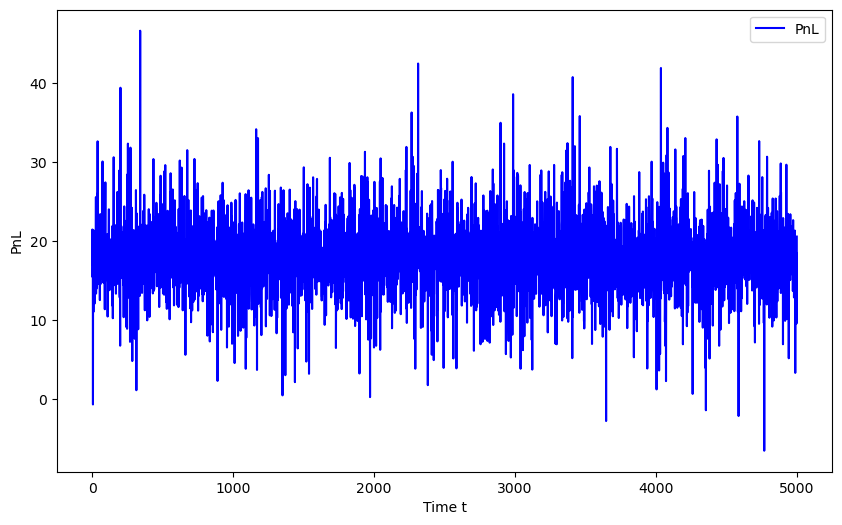

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(HFT1_1[0], color = 'blue', label = 'PnL')
plt.xlabel("Time t")
plt.ylabel("PnL")
plt.legend()
plt.show()

 2) Strategy 2 : ρ = 0.7, φ = 0.00001, alpha = 0 (no drift)

In [14]:
HFT1_2 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_2[0]))
print("The PnL standard deviation is :", np.std(HFT1_2[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 17.97568994918642
The PnL standard deviation is : 3.774689415983261


3) Strategy 3 : ρ = 1, φ = 0.00001, alpha = 1 (stochastic drift)

In [15]:
HFT1_3 = HFT_Strategy(n = 100, ρ = 1, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_3[0]))
print("The PnL standard deviation is :", np.std(HFT1_3[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 23.141438718449212
The PnL standard deviation is : 5.337381682981978


4) Strategy 4 : ρ = 1, φ = 0.00001, alpha = 0 (no drift)

In [16]:
HFT1_4 = HFT_Strategy(n = 100, ρ = 1, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_4[0]))
print("The PnL standard deviation is :", np.std(HFT1_4[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 23.487896549024484
The PnL standard deviation is : 6.081362153746713


5) Strategy 5 : ρ = 0, φ = 0.00001, alpha = 1 (stochastic drift)

In [17]:
HFT1_5 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_5[0]))
print("The PnL standard deviation is :", np.std(HFT1_5[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.405652694658706
The PnL standard deviation is : 3.275921130695821


6) Strategy 6 : ρ = 0, φ = 0.00001, alpha = 0 (no drift)

In [18]:
HFT1_6 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_6[0]))
print("The PnL standard deviation is :", np.std(HFT1_6[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.166563260614808
The PnL standard deviation is : 3.2905545116169854


7) Strategy 7 : ρ = 0.7, φ = 0.00002, alpha = 1 (stochastic drift)

In [19]:
HFT1_7 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_7[0]))
print("The PnL standard deviation is :", np.std(HFT1_7[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 18.060229853645737
The PnL standard deviation is : 3.932707554442139


8) Strategy 8 : ρ = 0.7, φ = 0.00002, alpha = 0 (no drift)

In [20]:
HFT1_8 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_8[0]))
print("The PnL standard deviation is :", np.std(HFT1_8[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 17.777063618529233
The PnL standard deviation is : 3.7086678879429


9) Strategy 9 : ρ = 1, φ = 0.00002, alpha = 1 (stochastic drift)

In [52]:
HFT1_9 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_9[0]))
print("The PnL standard deviation is :", np.std(HFT1_9[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 24.75031970796159
The PnL standard deviation is : 5.8567694612074


10) Strategy 10 : ρ = 1, φ = 0.00002, alpha = 0 (no drift)

In [22]:
HFT1_10 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_10[0]))
print("The PnL standard deviation is :", np.std(HFT1_10[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 23.948512204271875
The PnL standard deviation is : 4.837230085394069


11) Strategy 11 : ρ = 0, φ = 0.00002, alpha = 0 (stochastic drift)

In [23]:
HFT1_11 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_11[0]))
print("The PnL standard deviation is :", np.std(HFT1_11[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.363539395086523
The PnL standard deviation is : 3.3981443448472946


12) Strategy 12 : ρ = 0, φ = 0.00002, alpha = 0 (no drift)

In [24]:
HFT1_12 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00002, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_12[0]))
print("The PnL standard deviation is :", np.std(HFT1_12[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.341361962013288
The PnL standard deviation is : 3.1171276151024427


13) Strategy 13 : ρ = 0.7, φ = 0.00004, alpha = 1 (stochastic drift)

In [25]:
HFT1_13 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_13[0]))
print("The PnL standard deviation is :", np.std(HFT1_13[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 17.995686376335122
The PnL standard deviation is : 3.9829202905118186


14) Strategy 14 : ρ = 0.7, φ = 0.00004, alpha = 0 (no drift)

In [26]:
HFT1_14 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_14[0]))
print("The PnL standard deviation is :", np.std(HFT1_14[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 17.861316354912113
The PnL standard deviation is : 3.7325855196647693


15) Strategy 15 : ρ = 1, φ = 0.00004, alpha = 1 (stochastic drift)

In [27]:
HFT1_15 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_15[0]))
print("The PnL standard deviation is :", np.std(HFT1_15[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 23.45312514290913
The PnL standard deviation is : 6.146689267438718


16) Strategy 16 : ρ = 1, φ = 0.00004, alpha = 0 (no drift)

In [54]:
HFT1_16 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_16[0]))
print("The PnL standard deviation is :", np.std(HFT1_16[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 22.93480007976812
The PnL standard deviation is : 4.357476181690046


17) Strategy 17 : ρ = 0, φ = 0.00004, alpha = 1 (stochastic drift)

In [29]:
HFT1_17 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT1_17[0]))
print("The PnL standard deviation is :", np.std(HFT1_17[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.274726621086314
The PnL standard deviation is : 3.54286162515472


18) Strategy 18 : ρ = 0, φ = 0.00004, alpha = 0 (no drift)

In [30]:
HFT1_18 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00004, ε = 0.04, c_trans = 0.0001, alpha = 0)
print("The PnL mean is :", np.mean(HFT1_18[0]))
print("The PnL standard deviation is :", np.std(HFT1_18[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.229301453450656
The PnL standard deviation is : 3.195164253107079


In the following table, we will summurize the result of the first case.

In [55]:
data = {
    'φ': [0.00001, 0.00001, 0.00001, 0.00001, 0.00002, 0.00002,0.00002, 0.00002, 0.00004, 0.00004, 0.00004, 0.00004],
    'α_t': ['Yes', 'Yes','No','No', 'Yes', 'Yes','No','No','Yes','Yes', 'No','No'],
    'results' : ['mean', 'std','mean', 'std','mean', 'std','mean', 'std','mean', 'std','mean', 'std'],
    'ρ = 0.7': [np.mean(HFT1_1[0]), np.std(HFT1_1[0]), np.mean(HFT1_2[0]), np.std(HFT1_2[0]), np.std(HFT1_7[0]), np.mean(HFT1_7[0]),np.std(HFT1_8[0]), np.mean(HFT1_8[0]), np.std(HFT1_13[0]), np.mean(HFT1_13[0]),np.std(HFT1_14[0]), np.mean(HFT1_14[0])], 
    'ρ = 1': [np.mean(HFT1_3[0]), np.std(HFT1_3[0]), np.mean(HFT1_4[0]), np.std(HFT1_4[0]), np.std(HFT1_9[0]), np.mean(HFT1_9[0]),np.std(HFT1_10[0]), np.mean(HFT1_10[0]), np.std(HFT1_15[0]), np.mean(HFT1_15[0]),np.std(HFT1_16[0]), np.mean(HFT1_16[0])],
    'ρ = 0': [np.mean(HFT1_5[0]), np.std(HFT1_5[0]), np.mean(HFT1_6[0]), np.std(HFT1_6[0]), np.std(HFT1_11[0]), np.mean(HFT1_11[0]),np.std(HFT1_12[0]), np.mean(HFT1_12[0]), np.std(HFT1_17[0]), np.mean(HFT1_17[0]),np.std(HFT1_18[0]), np.mean(HFT1_18[0])] 
}
results1 = pd.DataFrame(data)
results1

,φ,α_t,results,ρ = 0.7,ρ = 1,ρ = 0
0,0.00001,Yes,mean,17.980663,23.141439,12.405653
1,0.00001,Yes,std,4.111919,5.337382,3.275921
2,0.00001,No,mean,17.975690,23.487897,12.166563
3,0.00001,No,std,3.774689,6.081362,3.290555
4,0.00002,Yes,mean,3.932708,5.856769,3.398144
5,0.00002,Yes,std,18.060230,24.750320,12.363539
6,0.00002,No,mean,3.708668,4.837230,3.117128
7,0.00002,No,std,17.777064,23.948512,12.341362
8,0.00004,Yes,mean,3.982920,6.146689,3.542862
9,0.00004,Yes,std,17.995686,23.453125,12.274727


The table clearly shows that market making is more profitable if the HFTs incorporate in their
optimal strategies predictions of short-term-alpha – this is true even if the HFTs incorrectly specify
the short-term-alpha parameters.

Now we will present a graphical comparison between the different results :

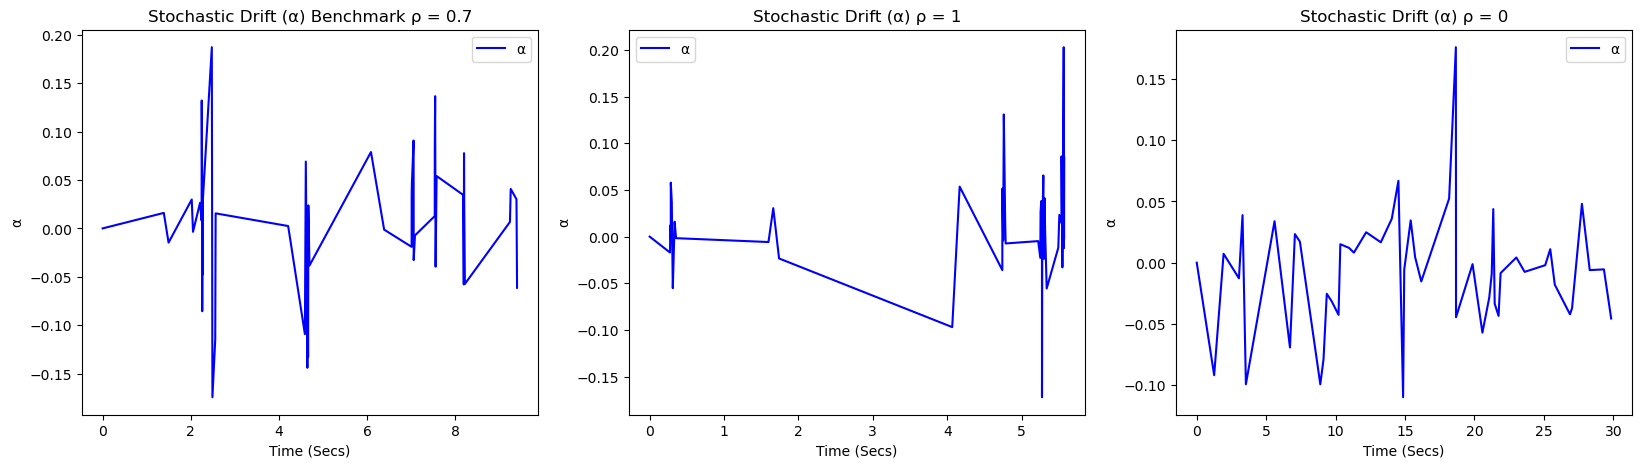

In [32]:
# Probability of the MO being influential
ρs = [0.7, 1, 0]
times = [HFT1_1[4][30], HFT1_3[4][30], HFT1_5[4][30]]
α_updateds = [HFT1_1[6][30], HFT1_3[6][30], HFT1_5[6][30]]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range (3):
    t = times[j][0:50]
    α_updated = α_updateds[j][0:50]
    
    axs[j].plot(t, α_updated, color='blue', label='α')
    axs[j].set_title('Stochastic Drift (α) ' + model[j])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('α')
    axs[j].legend()

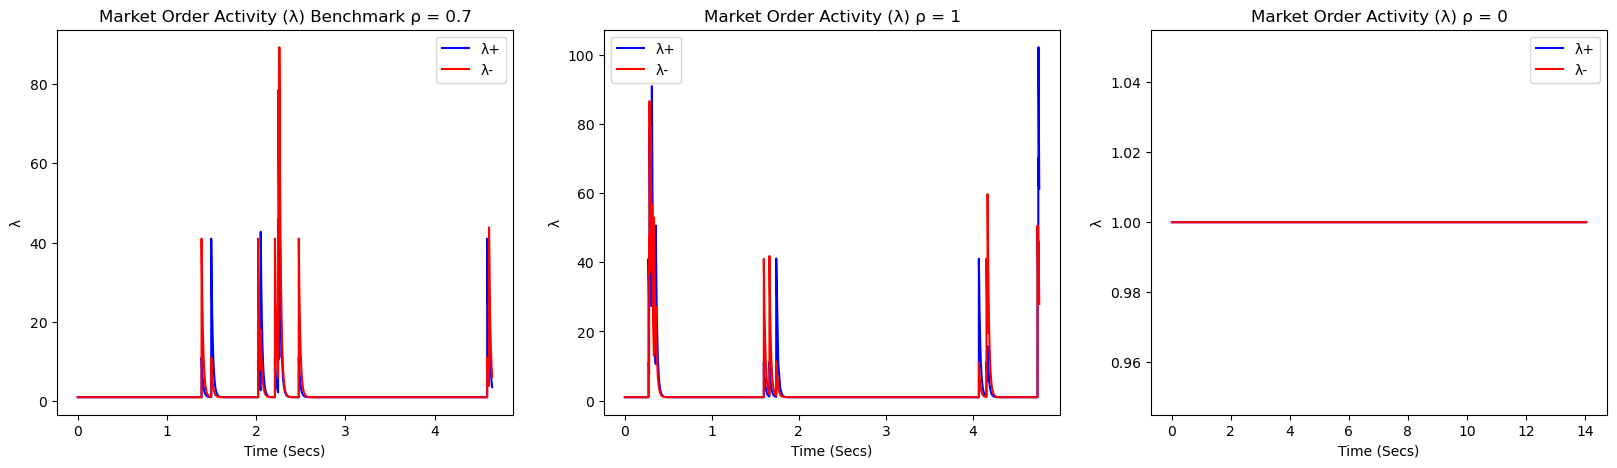

In [33]:
# Probability of the MO being influential
ρs = [0.7, 1, 0]
times = [HFT1_1[4][30], HFT1_3[4][30], HFT1_5[4][30]]
λs_plus_updateds = [HFT1_1[7][30], HFT1_3[7][30], HFT1_5[7][30]]
λs_minus_updateds = [HFT1_1[8][30], HFT1_3[8][30], HFT1_5[8][30]]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range (3):
    t = times[j]
    λ_plus_updated = λs_plus_updateds[j]
    λ_minus_updated = λs_minus_updateds[j]
    x_values = []
    λplus_values = []
    λminus_values = []
    
    for i in range(0, len(t[0:20])):
        x = np.linspace(t[i], t[i+1], 100) 
        λplus = θ + (λ_plus_updated[i] - θ) * np.exp(-β * (x - t[i]))
        λminus = θ + (λ_minus_updated[i] - θ) * np.exp(-β * (x - t[i]))
        x_values.extend(x)
        λplus_values.extend(λplus)
        λminus_values.extend(λminus)
    axs[j].plot(x_values, λplus_values, color='blue', label='λ+')
    axs[j].plot(x_values, λminus_values, color='red',label='λ-')
    axs[j].set_title('Market Order Activity (λ) ' + model[j])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('λ')
    axs[j].legend()

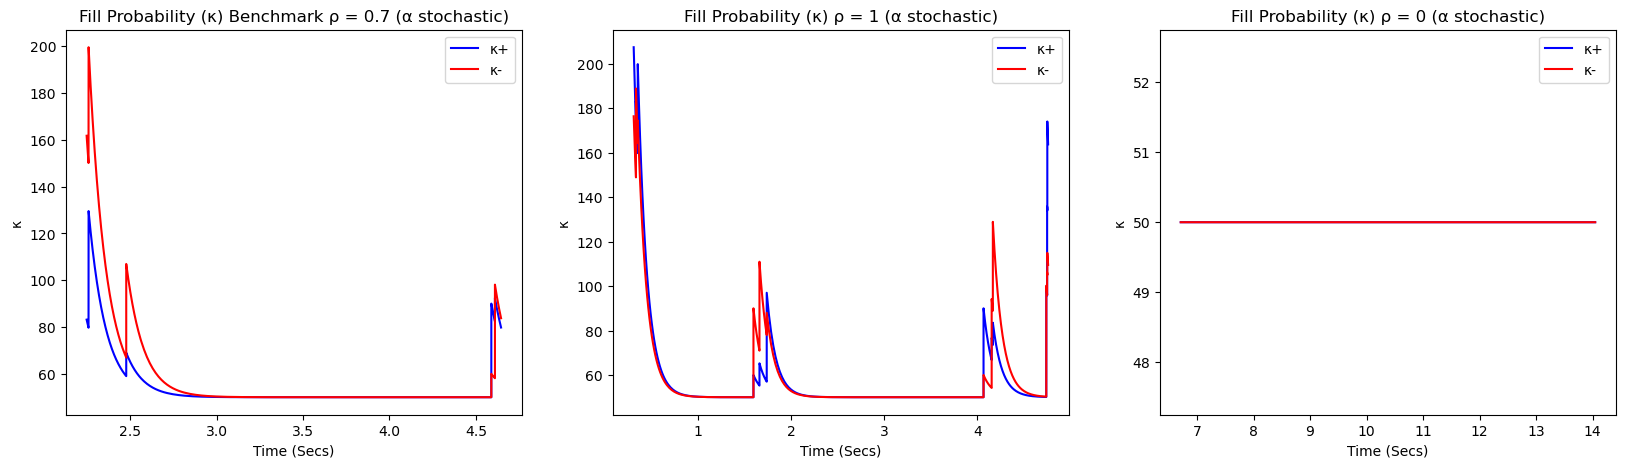

In [34]:
# Probability of the MO being influential
ρs = [0.7, 1, 0]
times = [HFT1_1[4][30], HFT1_3[4][30], HFT1_5[4][30]]
κpluss = [HFT1_1[9][30], HFT1_3[9][30], HFT1_5[9][30]]
κminuss = [HFT1_1[10][30], HFT1_3[10][30], HFT1_5[10][30]]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']
alphas = ['(α stochastic)', '(α = 0)']

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range (3):
    t = times[j]
    κplusvalues = κpluss[j]
    κminusvalues = κminuss[j]
    x_values = []
    κplus_values = []
    κminus_values = []
    
    for i in range(7, len(t[0:20])):
        x = np.linspace(t[i], t[i+1], 100) 
        κplus = ϑ_ + (κplusvalues[i] - ϑ_) * np.exp(-ξ * (x - t[i]))
        κminus = ϑ_ + (κminusvalues[i] - ϑ_) * np.exp(-ξ * (x - t[i]))
        x_values.extend(x)
        κplus_values.extend(κplus)
        κminus_values.extend(κminus)
    axs[j].plot(x_values, κplus_values, color='blue', label='κ+')
    axs[j].plot(x_values, κminus_values, color='red',label='κ-')
    axs[j].set_title('Fill Probability (κ) ' + model[j]+ ' ' + alphas[0])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('κ')
    axs[j].legend()

We have ploted for the three models a sample path of the traders interpretation of the stochastic drift, market order activity, and fill probability parameter. 
The benchmark model has the correct data generating path, while the others under- or over-estimate the role of trade arrivals.

We deduce that as the dynamics of $α_t$ show over approximately a 5 seconds window. We see that for this particular time interval of the simulation, αt is sometimes negative, and every time an influential order arrives the stochastic drift jumps up (buy market order) or down(sell market order) by a random amount which is drawn from an exponential distribution with mean ε = 0.04.

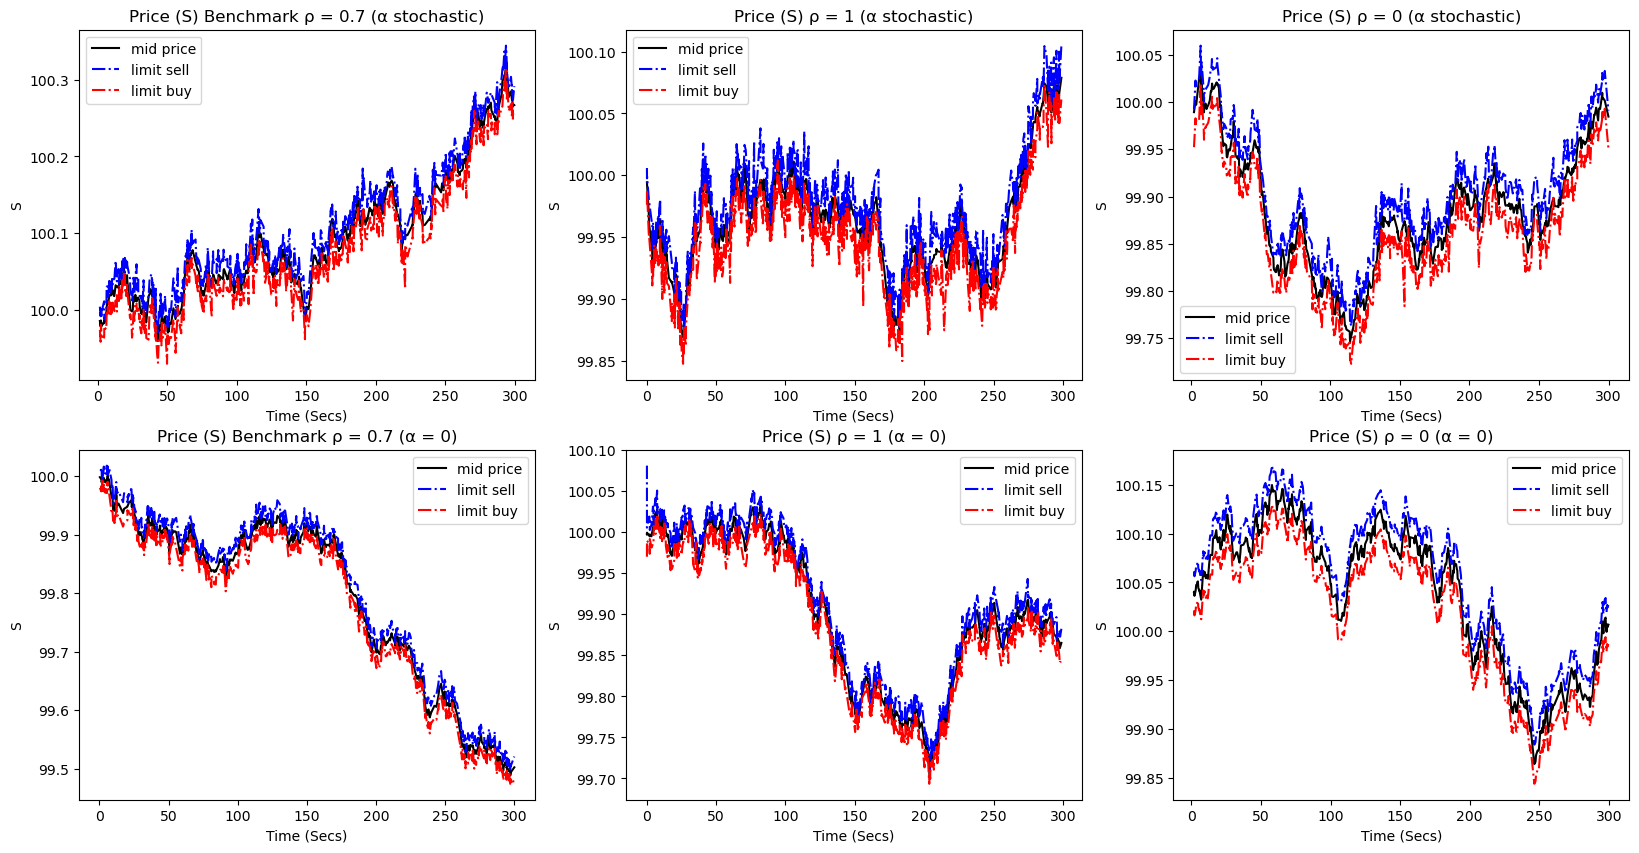

In [35]:
# Probability of the MO being influential
ρs = [0.7, 1, 0]
times = [[HFT1_1[4][30], HFT1_3[4][30], HFT1_5[4][30]], [HFT1_2[4][30], HFT1_4[4][30], HFT1_6[4][30]]]
S_samples = [[HFT1_1[1][30], HFT1_3[1][30], HFT1_5[1][30]], [HFT1_2[1][30], HFT1_4[1][30], HFT1_6[1][30]]]
S_plus_δ_samples = [[HFT1_1[2][30], HFT1_3[2][30], HFT1_5[2][30]], [HFT1_2[2][30], HFT1_4[2][30], HFT1_6[2][30]]]
S_minus_δ_samples = [[HFT1_1[3][30], HFT1_3[3][30], HFT1_5[3][30]], [HFT1_2[3][30], HFT1_4[3][30], HFT1_6[3][30]]]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']
alphas = ['(α stochastic)', '(α = 0)']

# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range (2):
    for j in range(3) : 
        t = times[i][j][2:]
        S_sample = S_samples[i][j][2:]
        S_plus_δ_sample = S_plus_δ_samples[i][j][2:]
        S_minus_δ_sample = S_minus_δ_samples[i][j][2:]
        axs[i][j].plot(t, S_sample, color = 'black',label = 'mid price')
        axs[i][j].plot(t, S_plus_δ_sample, color = 'blue',label = 'limit sell', linestyle = '-.')
        axs[i][j].plot(t, S_minus_δ_sample, color = 'red',label = 'limit buy', linestyle = '-.')
        
        axs[i][j].set_title('Price (S) ' + model[j] + ' ' + alphas[i])
        axs[i][j].set_xlabel('Time (Secs)')
        axs[i][j].set_ylabel('S')
        axs[i, j].get_yaxis().get_major_formatter().set_useOffset(False)
        axs[i][j].legend()

We noticed that when influential trades arrive, the activity of both buy and sell orders increase
but by differing amounts, the FP parameters also jump, and both decay to their long-run levels. Circles indicate the arrival of an influential market order, while squares indicate the arrival of non-influential trades. Open symbols indicate those market orders which do not fill the traders limit orders, while filled in symbols indicate those market orders which do fill the traders limit orders.

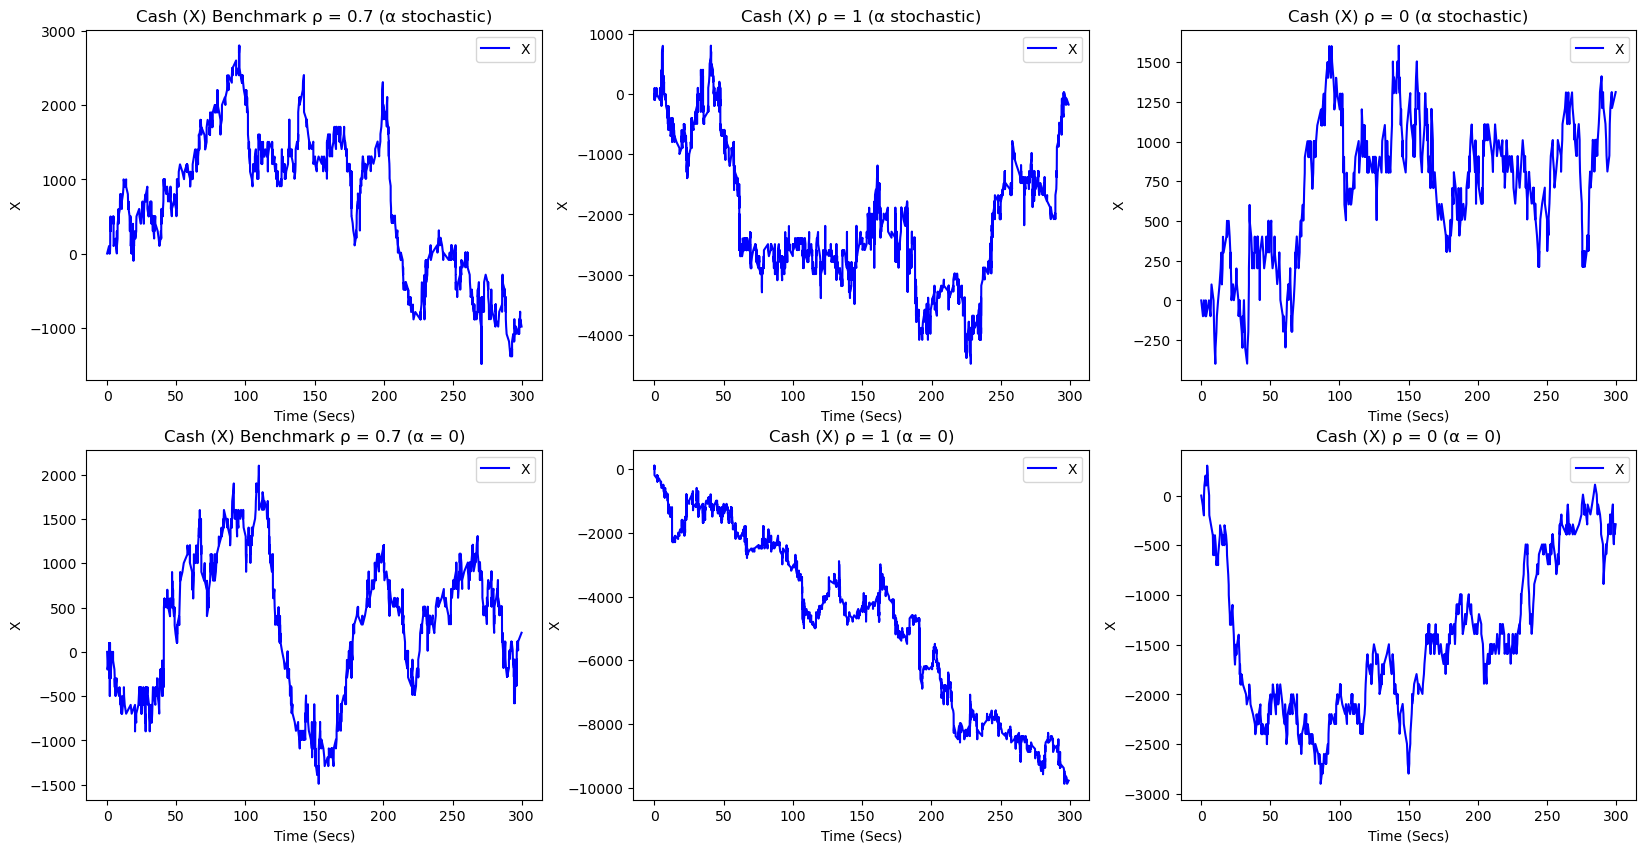

In [36]:
# Probability of the MO being influential
ρs = [0.7, 1, 0]
times = [[HFT1_1[4][30], HFT1_3[4][30], HFT1_5[4][30]], [HFT1_2[4][30], HFT1_4[4][30], HFT1_6[4][30]]]
X_samples = [[HFT1_1[5][30], HFT1_3[5][30], HFT1_5[5][30]], [HFT1_2[5][30], HFT1_4[5][30], HFT1_6[5][30]]]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']
alphas = ['(α stochastic)', '(α = 0)']

# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range (2):
    for j in range(3) : 
        t = times[i][j]
        X_sample = X_samples[i][j]
        axs[i][j].plot(t, X_sample, color = 'blue',label = 'X')
        
        axs[i][j].set_title('Cash (X) ' + model[j] + ' ' + alphas[i])
        axs[i][j].set_xlabel('Time (Secs)')
        axs[i][j].set_ylabel('X')
        axs[i, j].get_yaxis().get_major_formatter().set_useOffset(False)
        axs[i][j].legend()

<h3> Case 2 : ε = 0.04 and c_trans = 0.001 (10BP)</h3>

1) Strategy 1 : ρ = 0.7, φ = 0.00001, alpha = 1

In [37]:
HFT2_1 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00001, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_1[0]))
print("The PnL standard deviation is :", np.std(HFT2_1[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.81517452851895
The PnL standard deviation is : 4.3375818706112055


 2) Strategy 2 : ρ = 0.7, φ = 0.00001, alpha = 0 (no drift)

In [38]:
HFT2_2 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00001, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_2[0]))
print("The PnL standard deviation is :", np.std(HFT2_2[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.713104516355639
The PnL standard deviation is : 4.223118129805257


3) Strategy 3 : ρ = 1, φ = 0.00001, alpha = 1 (stochastic drift)

In [56]:
HFT2_3 = HFT_Strategy(n = 100, ρ = 1, φ = 0.00001, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_3[0]))
print("The PnL standard deviation is :", np.std(HFT2_3[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 21.0704942654823
The PnL standard deviation is : 5.845280170534666


4) Strategy 4 : ρ = 1, φ = 0.00001, alpha = 0 (no drift)

In [59]:
HFT2_4 = HFT_Strategy(n = 100, ρ = 1, φ = 0.00001, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_4[0]))
print("The PnL standard deviation is :", np.std(HFT2_4[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 21.099652861356844
The PnL standard deviation is : 4.827861052558696


5) Strategy 5 : ρ = 0, φ = 0.00001, alpha = 1 (stochastic drift)

In [41]:
HFT2_5 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00001, ε = 0.04, c_trans = 0.0001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_5[0]))
print("The PnL standard deviation is :", np.std(HFT2_5[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 12.328925997272288
The PnL standard deviation is : 3.4768224186051913


6) Strategy 6 : ρ = 0, φ = 0.00001, alpha = 0 (no drift)

In [42]:
HFT2_6 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00001, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_6[0]))
print("The PnL standard deviation is :", np.std(HFT2_6[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 10.510562691630664
The PnL standard deviation is : 3.527327730944762


7) Strategy 7 : ρ = 0.7, φ = 0.00002, alpha = 1 (stochastic drift)

In [43]:
HFT2_7 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_7[0]))
print("The PnL standard deviation is :", np.std(HFT2_7[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.877921533106896
The PnL standard deviation is : 4.336744990661854


8) Strategy 8 : ρ = 0.7, φ = 0.00002, alpha = 0 (no drift)

In [44]:
HFT2_8 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_8[0]))
print("The PnL standard deviation is :", np.std(HFT2_8[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.695799525577918
The PnL standard deviation is : 4.0871726902978525


9) Strategy 9 : ρ = 1, φ = 0.00002, alpha = 1 (stochastic drift)

In [45]:
HFT2_9 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_9[0]))
print("The PnL standard deviation is :", np.std(HFT2_9[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 21.52862584237266
The PnL standard deviation is : 5.43024709993845


10) Strategy 10 : ρ = 1, φ = 0.00002, alpha = 0 (no drift)

In [46]:
HFT2_10 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_10[0]))
print("The PnL standard deviation is :", np.std(HFT2_10[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 21.366324840043788
The PnL standard deviation is : 5.432708226219382


11) Strategy 11 : ρ = 0, φ = 0.00002, alpha = 0 (stochastic drift)

In [47]:
HFT2_11 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_11[0]))
print("The PnL standard deviation is :", np.std(HFT2_11[0]))    

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 10.554630453473584
The PnL standard deviation is : 3.7234755176280716


12) Strategy 12 : ρ = 0, φ = 0.00002, alpha = 0 (no drift)

In [48]:
HFT2_12 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00002, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_12[0]))
print("The PnL standard deviation is :", np.std(HFT2_12[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 10.542430653379766
The PnL standard deviation is : 3.4116812149979734


13) Strategy 13 : ρ = 0.7, φ = 0.00004, alpha = 1 (stochastic drift)

In [49]:
HFT2_13 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_13[0]))
print("The PnL standard deviation is :", np.std(HFT2_13[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.931608338799732
The PnL standard deviation is : 4.368195796475935


14) Strategy 14 : ρ = 0.7, φ = 0.00004, alpha = 0 (no drift)

In [64]:
HFT2_14 = HFT_Strategy(n = 5000, ρ = 0.7, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_14[0]))
print("The PnL standard deviation is :", np.std(HFT2_14[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 15.712520202370733
The PnL standard deviation is : 4.172809267884876


15) Strategy 15 : ρ = 1, φ = 0.00004, alpha = 1 (stochastic drift)

In [60]:
HFT2_15 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_15[0]))
print("The PnL standard deviation is :", np.std(HFT2_15[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 20.305414373890244
The PnL standard deviation is : 6.98510892212749


16) Strategy 16 : ρ = 1, φ = 0.00004, alpha = 0 (no drift)

In [61]:
HFT2_16 = HFT_Strategy(n = 100, ρ = 1.0, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_16[0]))
print("The PnL standard deviation is :", np.std(HFT2_16[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 20.904938436073625
The PnL standard deviation is : 5.289817862032866


17) Strategy 17 : ρ = 0, φ = 0.00004, alpha = 1 (stochastic drift)

In [62]:
HFT2_17 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 1)
print("The PnL mean is :", np.mean(HFT2_17[0]))
print("The PnL standard deviation is :", np.std(HFT2_17[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 10.663021085067884
The PnL standard deviation is : 3.679408771618889


18) Strategy 18 : ρ = 0, φ = 0.00004, alpha = 0 (no drift)

In [63]:
HFT2_18 = HFT_Strategy(n = 5000, ρ = 0, φ = 0.00004, ε = 0.04, c_trans = 0.001, alpha = 0)
print("The PnL mean is :", np.mean(HFT2_18[0]))
print("The PnL standard deviation is :", np.std(HFT2_18[0]))

C:\Users\33603\AppData\Local\Temp\ipykernel_10888\1872089480.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*θ))* (λ - 2*θ) * float(mp.exp(ς))))


The PnL mean is : 10.440278631350747
The PnL standard deviation is : 3.4813212325658998


In the following table, we will summurize the result of the second case.

In [65]:
data2 = {
    'φ': [0.00001, 0.00001, 0.00001, 0.00001, 0.00002, 0.00002,0.00002, 0.00002, 0.00004, 0.00004, 0.00004, 0.00004],
    'α_t': ['Yes', 'Yes','No','No', 'Yes', 'Yes','No','No','Yes','Yes', 'No','No'],
    'results' : ['mean', 'std','mean', 'std','mean', 'std','mean', 'std','mean', 'std','mean', 'std'],
    'ρ = 0.7': [np.mean(HFT2_1[0]), np.std(HFT2_1[0]), np.mean(HFT2_2[0]), np.std(HFT2_2[0]), np.std(HFT1_7[0]), np.mean(HFT2_7[0]),np.std(HFT2_8[0]), np.mean(HFT2_8[0]), np.std(HFT2_13[0]), np.mean(HFT2_13[0]),np.std(HFT2_14[0]), np.mean(HFT2_14[0])], 
    'ρ = 1': [np.mean(HFT2_3[0]), np.std(HFT2_3[0]), np.mean(HFT2_4[0]), np.std(HFT2_4[0]), np.std(HFT1_9[0]), np.mean(HFT2_9[0]),np.std(HFT2_10[0]), np.mean(HFT2_10[0]), np.std(HFT2_15[0]), np.mean(HFT2_15[0]),np.std(HFT2_16[0]), np.mean(HFT2_16[0])],
    'ρ = 0': [np.mean(HFT2_5[0]), np.std(HFT2_5[0]), np.mean(HFT2_6[0]), np.std(HFT2_6[0]), np.std(HFT1_11[0]), np.mean(HFT2_11[0]),np.std(HFT2_12[0]), np.mean(HFT2_12[0]), np.std(HFT2_17[0]), np.mean(HFT2_17[0]),np.std(HFT2_18[0]), np.mean(HFT2_18[0])] 
}
results2 = pd.DataFrame(data)
results2

,φ,α_t,results,ρ = 0.7,ρ = 1,ρ = 0
0,0.00001,Yes,mean,17.980663,23.141439,12.405653
1,0.00001,Yes,std,4.111919,5.337382,3.275921
2,0.00001,No,mean,17.975690,23.487897,12.166563
3,0.00001,No,std,3.774689,6.081362,3.290555
4,0.00002,Yes,mean,3.932708,5.856769,3.398144
5,0.00002,Yes,std,18.060230,24.750320,12.363539
6,0.00002,No,mean,3.708668,4.837230,3.117128
7,0.00002,No,std,17.777064,23.948512,12.341362
8,0.00004,Yes,mean,3.982920,6.146689,3.542862
9,0.00004,Yes,std,17.995686,23.453125,12.274727


<h3> Conclusion : </h3>

We devised an HF trading strategy focusing on the HFT's speed advantage, distinguishing influential and non-influential market orders.

We conclude that our model incorporates short-term alpha prediction, optimizing limit order placement based on an optimal control framework. Simulations reveal profitable outcomes for HFTs leveraging short-term price deviations. We acknowledge a gap in our model regarding optimal market order execution timing. Additionally, our model captures the self-exciting nature of market manipulation, though further analysis is needed.